In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd
import scipy.stats as spst

import argus_shapes
import pulse2percept.implants as p2pi
import pulse2percept.retina as p2pr
import pulse2percept.utils as p2pu

import skimage.io as skio
import skimage.transform as skit

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-08-03 22:04:42,268 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
results_dir = '../../results/trial1cv'
col_score = 'best_train_score'
col_groupby = ['subject', 'modelname', 'idx_fold']

In [3]:
class ShapeLoss(argus_shapes.models.ShapeLossMixin):
    def _calcs_el_curr_map(self):
        pass
    def build_ganglion_cell_layer(self):
        pass
shape_loss = ShapeLoss()

In [4]:
files = argus_shapes.extract_best_pickle_files(results_dir, col_score, col_groupby)

In [5]:
y_true = []
y_pred = []
for file in files:
    yt, yp, _, specifics = pickle.load(open(file, 'rb'))
    yt = yt[0].drop(columns=['image', 'x_center', 'y_center'])
    yp = yp[0].drop(columns=['image', 'x_center', 'y_center'])
    for g in col_groupby:
        yt[g] = specifics[g]
    yt['orientation'] = np.rad2deg(yt['orientation'])
    yp['orientation'] = np.rad2deg(yp['orientation'])
    y_true.append(yt)
    y_pred.append(yp)
ytyp = pd.concat((pd.concat(y_true),
                  pd.concat(y_pred).add_suffix('_p')),
                 axis=1)

In [6]:
subjects = ytyp.subject.unique().tolist()
subjects

['S1', 'S2', 'S3', 'S4']

In [7]:
markers = ['o', 's', 'v', '^']
colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']
all_ticks = (([0, 16], [0, 2400], [-90, 90], [0, 1]),
             ([0, 16], [0, 6000], [-90, 90], [0, 1]),
             ([0, 16], [0, 2000], [-90, 90], [0, 1]),
             ([0, 16], [0, 18000], [-90, 90], [0, 1]))
labels = ['n/a', 'area (pixels)', 'orientation (deg)', 'elongation']

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


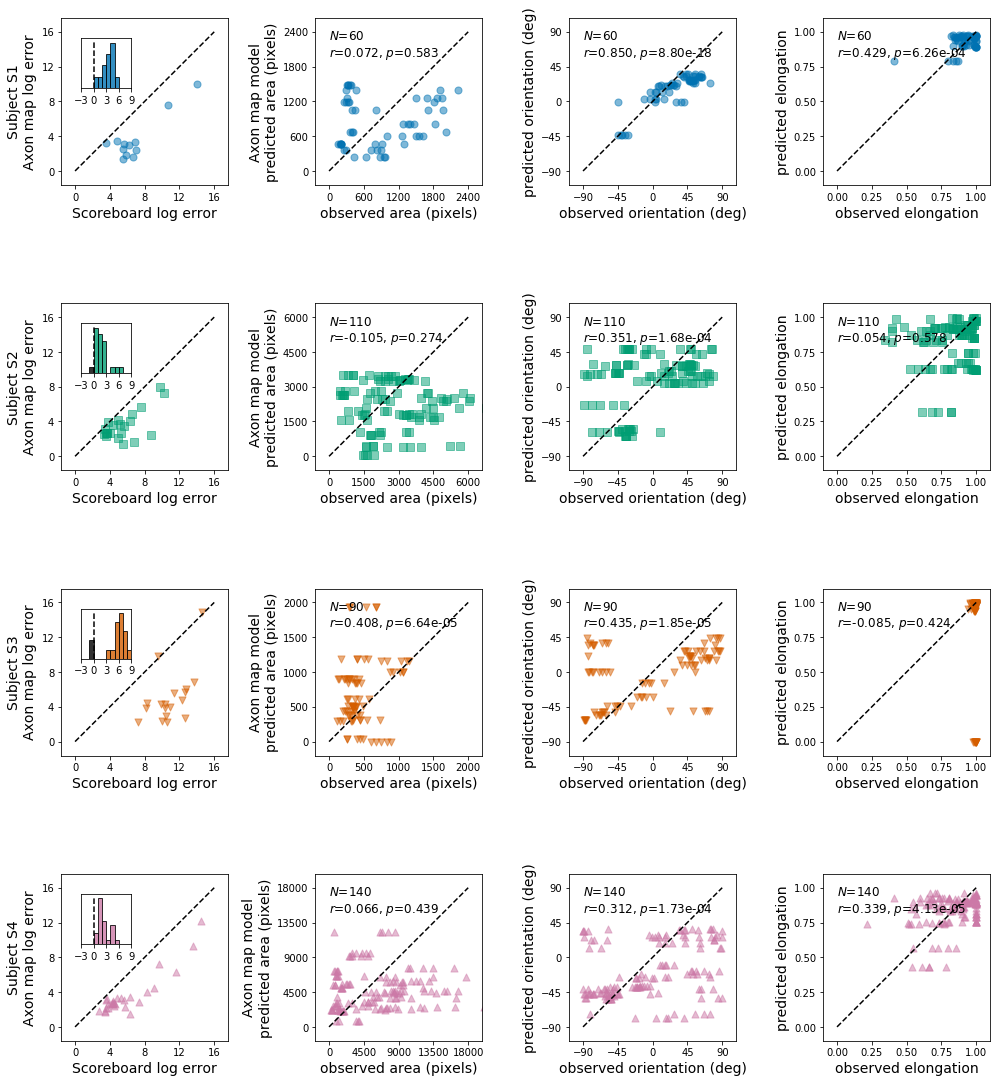

In [8]:
plotcols = ['AvsC', 'area', 'orientation', 'eccentricity']
fs = 14
fig, axes = plt.subplots(ncols=len(plotcols), nrows=len(subjects), 
                         figsize=(14, 4 * len(subjects)))
for (subject, data), marker, color, ticks, axrow in zip(ytyp.groupby('subject'), markers, colors, all_ticks, axes):
    for col, ax, tick, label in zip(plotcols, axrow, ticks, labels):
        lim = [1.1 * tick[0] - 0.1 * tick[1], 1.1 * tick[1] - 0.1 * tick[0]]
        if col == 'AvsC':
            # First column: show Model A vs Model C scatter plot
            xvals = []
            yvals = []
            for (_, rows) in data.groupby('idx_fold'):
                rows_a = rows[rows.modelname == 'A']
                rows_c = rows[rows.modelname == 'C']
                xvals.append(shape_loss.calc_shape_loss(rows_a, rows_a, suffix='_p'))
                yvals.append(shape_loss.calc_shape_loss(rows_c, rows_c, suffix='_p'))
            ax.scatter(np.log(xvals), np.log(yvals), marker=marker, s=50, c=color, alpha=0.5)
            ax.set_xlabel('Scoreboard log error', fontsize=fs)
            ax.set_ylabel('Subject %s\nAxon map log error' % subject, fontsize=fs)
            
            axins = inset_axes(ax, width="30%", height="30%", loc=2, borderpad=2)
            n, bins, patches = axins.hist(np.log(xvals) - np.log(yvals), 
                                          bins=12, range=(-3, 9), 
                                          color=color, alpha=0.8)
            [patches[i].set_facecolor('k') for i in range(3)]
            [p.set_edgecolor('k') for p in patches]
            a = axins.axis()
            axins.plot([0, 0], [0, a[3]], 'k--')
            axins.set_yticks([])
            axins.set_xticks(np.linspace(-3, 9, num=5))
            axins.set_xlim(-3, 9)
        else:
            rows = data[data.modelname == 'C']
            ax.scatter(rows[col], rows[col + '_p'], marker=marker, s=50, c=color, alpha=0.5)
            ax.set_xlabel('observed %s' % label, fontsize=fs)
            ax.set_ylabel('predicted %s' % label, fontsize=fs)
            slope, intercept, rval, pval, _ = spst.linregress(rows[col], rows[col + '_p'])
            if pval >= 0.001:
                ax.text(tick[0], tick[1], "$N$=%d\n$r$=%.3f, $p$=%.3f" % (len(rows), rval, pval), 
                        va='top', ha='left', fontsize=fs - 2)
            else:
                ax.text(tick[0], tick[1], "$N$=%d\n$r$=%.3f, $p$=%.2e" % (len(rows), rval, pval), 
                        va='top', ha='left', fontsize=fs - 2)
        ax.plot([tick[0], tick[1]], [tick[0], tick[1]], 'k--')
        ax.axis('square')
        ax.set_xticks(np.linspace(*tick, num=5))
        ax.set_yticks(np.linspace(*tick, num=5))
        ax.set_xlim(*lim)
        ax.set_ylim(*lim)
    axrow[1].set_ylabel('Axon map model\npredicted %s' % labels[1], fontsize=fs)
fig.tight_layout();
fig.savefig('fig7-scatter-axonmap.eps')
# fig.savefig('fig7-scatter-axonmap.png')